<a href="https://colab.research.google.com/github/jackdaus/egolifter/blob/colab/00_sam-example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAM Example

A simple example of running SAM.

In [1]:
import cv2
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
from PIL import Image
import requests
import os

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True


In [2]:
# If this is Colab, then we need to install SAM on the fly
if 'google.colab' in str(get_ipython()):
    # Install segment-anything using pip in Colab
    !pip install -q git+https://github.com/facebookresearch/segment-anything.git
    print("segment-anything installed successfully in Colab.")
else:
    print("Not running in Colab, skipping segment-anything installation.")

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

  Preparing metadata (setup.py) ... done
segment-anything installed successfully in Colab.


In [3]:
if os.path.exists("test.jpg"):
  image = cv2.imread('test.jpg')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
else:
  # Download image on the fly
  image_url = "https://raw.githubusercontent.com/jackdaus/egolifter/refs/heads/main/test.jpg"
  response = requests.get(image_url)
  image_content = response.content
  image = Image.open(BytesIO(image_content))
  image = np.array(image)
  if image.shape[2] == 4:  # If RGBA, convert to RGB
      image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

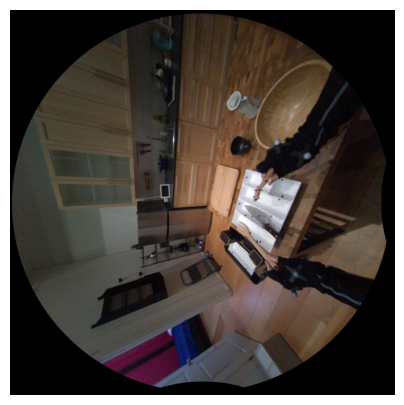

In [4]:
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()

In [5]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [6]:
# Download the model weights if not already present
if not os.path.exists('sam_vit_h_4b8939.pth'):
    print("Downloading model weights sam_vit_h_4b8939.pth...")
    url = 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'
    response = requests.get(url)
    with open('sam_vit_h_4b8939.pth', 'wb') as f:
        f.write(response.content)
else:
    print("Model weights sam_vit_h_4b8939.pth already downloaded.")

In [7]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

# Assumes you have a GPU available
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device="cuda")

mask_generator = SamAutomaticMaskGenerator(sam)

In [8]:
masks = mask_generator.generate(image)

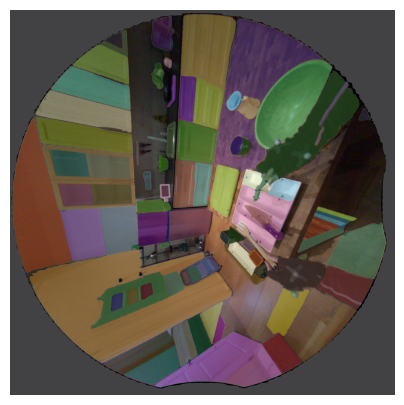

In [9]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [10]:
# Try the smaller model
model_file_sam_vit_b = "sam_vit_b_01ec64.pth"
if not os.path.exists(model_file_sam_vit_b):
    print(f"Downloading model weights {model_file_sam_vit_b}...")
    url = f'https://dl.fbaipublicfiles.com/segment_anything/{model_file_sam_vit_b}'
    response = requests.get(url)
    with open(model_file_sam_vit_b, 'wb') as f:
        f.write(response.content)
else:
    print(f"Model weights {model_file_sam_vit_b} already downloaded.")

In [11]:
sam = sam_model_registry["vit_b"](checkpoint=model_file_sam_vit_b).to(device="cuda")
mask_generator = SamAutomaticMaskGenerator(sam)

In [12]:
masks = mask_generator.generate(image)

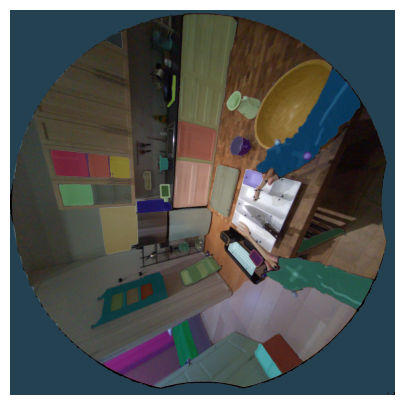

In [13]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()